<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
Non-Linear Least Squares Optimization
</h1>

Christian Bauckhage: "NumPy / SciPy Recipes for Data Science:
Non-Linear Least Squares Optimization", Technical Report, March 2015 ([Download from ResearchGate](https://www.researchgate.net/publication/273872578_NumPy_SciPy_Recipes_for_Data_Science_Non-Linear_Least_Squares_Optimization))
  
<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
import numpy.polynomial as pol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def create_data_2D(n, w, xmin, xmax):
    x = rnd.random(n) * (xmax-xmin) + xmin
    X = np.vander(x, len(w))
    y = np.dot(X, w) + rnd.randn(n) + 0.5
    return x,y

In [3]:
# Example of the behavior from the two Functions 'numpy.vander' and 
# numpy.polynomial.polynomial.polyvander

a = np.array([1, 2, 3, 4])
np.vander(a, 3)

array([[ 1,  1,  1],
       [ 4,  2,  1],
       [ 9,  3,  1],
       [16,  4,  1]])

In [4]:
# polyvander understands the the second Parameter (3) as the degree of
# the corresponding polynomial

pol.polynomial.polyvander(a, 3)

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

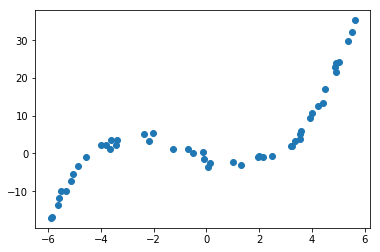

In [5]:
w = np.array([0.2, 0.4, -2.1, -1.5])
x, y = create_data_2D(50, w, -6, 6)
plt.scatter(x, y);

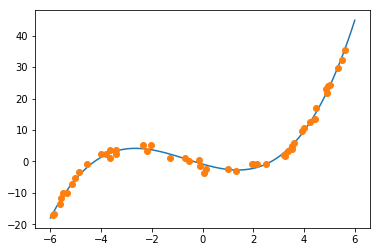

In [6]:
# rcond Future Warning (lstsq)

w = la.lstsq(np.vander(x, 4), y, rcond=None)[0]
xs = np.linspace(-6, 6, 100)
ys = np.dot(np.vander(xs, 4), w)

plt.plot(xs, ys, '-')
plt.plot(x, y, 'o');

In [7]:
# Fehler im Paper
# Differnce between 'create_data_2D' and 'create_data_3d' is the use of
# the function polyvander2d

def create_data_3D(n, v, p, q, xmin, xmax, ymin, ymax):
    x = rnd.random(n) * (xmax-xmin) + xmin
    y = rnd.random(n) * (ymax-ymin) + ymin
    
    Y = pol.polynomial.polyvander2d(x, y, [p, q])
    z = np.dot(Y, v) + rnd.randn(n) * 0.5
    
    return x, y, z

In [8]:
# rcond Future Warning (lstsq)

v = np.array([1., 0.5, 0.5, -2.])
x, y, z = create_data_3D(100,v,1,1,-2,2,-2,2)
Y = pol.polynomial.polyvander2d(x, y, [1, 1])
v = la.lstsq(Y, z, rcond=None)[0]

In [9]:
def plot_bilinear_model(x, y, z, v, xmin, xmax, ymin, ymax):
    xs = np.linspace(xmin, xmax, 21)
    ys = np.linspace(ymin, ymax, 21)
    
    V = v.reshape(2,2)
    Z = pol.polynomial.polygrid2d(xs, ys, V)
    
    X, Y = np.meshgrid(xs, ys)
    
    fig = plt.figure()
    axs = Axes3D(fig)
    
    axs.plot_wireframe(X, Y, Z)
    axs.scatter(x, y, z)
    
      
    plt.show()
     

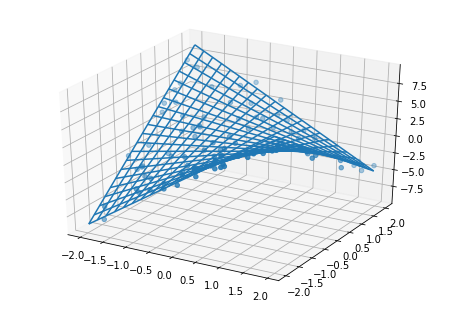

In [10]:
plot_bilinear_model(x, y, z, v, x.min(), x.max(), y.min(), y.max())

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; C. Bauckhage and O. Cremers<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>